<a href="https://colab.research.google.com/github/AI4Finance-Foundation/FinRL/blob/master/tutorials/tutorial_multistock_variant_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Reinforcement Learning for Stock Trading from Scratch: Multiple Stock Trading

Tutorials to use OpenAI DRL to trade multiple stocks in one Jupyter Notebook | Presented at NeurIPS 2020: Deep RL Workshop

* This blog is based on our paper: FinRL: A Deep Reinforcement Learning Library for Automated Stock Trading in Quantitative Finance, presented at NeurIPS 2020: Deep RL Workshop.
* Check out medium blog for detailed explanations: https://towardsdatascience.com/finrl-for-quantitative-finance-tutorial-for-multiple-stock-trading-7b00763b7530
* Please report any issues to our Github: https://github.com/AI4Finance-LLC/FinRL-Library/issues
* **Pytorch Version** 



# Content

* [1. Problem Definition](#0)
* [2. Getting Started - Load Python packages](#1)
    * [2.1. Install Packages](#1.1)    
    * [2.2. Check Additional Packages](#1.2)
    * [2.3. Import Packages](#1.3)
    * [2.4. Create Folders](#1.4)
* [3. Download Data](#2)
* [4. Preprocess Data](#3)        
    * [4.1. Technical Indicators](#3.1)
    * [4.2. Perform Feature Engineering](#3.2)
* [5.Build Environment](#4)  
    * [5.1. Training & Trade Data Split](#4.1)
    * [5.2. User-defined Environment](#4.2)   
    * [5.3. Initialize Environment](#4.3)    
* [6.Implement DRL Algorithms](#5)  
* [7.Backtesting Performance](#6)  
    * [7.1. BackTestStats](#6.1)
    * [7.2. BackTestPlot](#6.2)   
    * [7.3. Baseline Stats](#6.3)   
    * [7.3. Compare to Stock Market Index](#6.4)             

<a id='0'></a>
# Part 1. Problem Definition

This problem is to design an automated trading solution for single stock trading. We model the stock trading process as a Markov Decision Process (MDP). We then formulate our trading goal as a maximization problem.

The algorithm is trained using Deep Reinforcement Learning (DRL) algorithms and the components of the reinforcement learning environment are:


* Action: The action space describes the allowed actions that the agent interacts with the
environment. Normally, a ∈ A includes three actions: a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying one stock. Also, an action can be carried upon multiple shares. We use
an action space {−k, ..., −1, 0, 1, ..., k}, where k denotes the number of shares. For example, "Buy
10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* Reward function: r(s, a, s′) is the incentive mechanism for an agent to learn a better action. The change of the portfolio value when action a is taken at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio
values at state s′ and s, respectively

* State: The state space describes the observations that the agent receives from the environment. Just as a human trader needs to analyze various information before executing a trade, so
our trading agent observes many different features to better learn in an interactive environment.

* Environment: Dow 30 consituents


The data of the single stock that we will be using for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.


<a id='1'></a>
# Part 2. Getting Started- ASSUMES USING DOCKER, see readme for instructions

<a id='1.1'></a>
## 2.1. Add FinRL to your path. You can of course install it as a pipy package, but this is for development purposes.


In [ ]:
import sys

sys.path.append("..")

In [ ]:
import pandas as pd
print(pd.__version__)

1.1.5



<a id='1.2'></a>
## 2.2. Check if the additional packages needed are present, if not install them. 
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow
* pyfolio

<a id='1.3'></a>
## 2.3. Import Packages

In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl import config
from finrl.neo_finrl.preprocessor.yahoodownloader import YahooDownloader
from finrl.neo_finrl.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.neo_finrl.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

from pprint import pprint

<a id='1.4'></a>
## 2.4. Create Folders

In [ ]:
import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

<a id='2'></a>
# Part 3. Download Data
Yahoo Finance is a website that provides stock data, financial news, financial reports, etc. All the data provided by Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** to fetch data from Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).




-----
class YahooDownloader:
    Provides methods for retrieving daily stock data from
    Yahoo Finance API

    Attributes
    ----------
        start_date : str
            start date of the data (modified from config.py)
        end_date : str
            end date of the data (modified from config.py)
        ticker_list : list
            a list of stock tickers (modified from config.py)

    Methods
    -------
    fetch_data()
        Fetches data from yahoo API


In [ ]:
# from config.py start_date is a string
config.START_DATE

'2009-01-01'

In [ ]:
# from config.py end_date is a string
config.END_DATE

'2021-01-01'

In [ ]:
print(config.DOW_30_TICKER)

['AAPL', 'MSFT', 'JPM', 'V', 'RTX', 'PG', 'GS', 'NKE', 'DIS', 'AXP', 'HD', 'INTC', 'WMT', 'IBM', 'MRK', 'UNH', 'KO', 'CAT', 'TRV', 'JNJ', 'CVX', 'MCD', 'VZ', 'CSCO', 'XOM', 'BA', 'MMM', 'PFE', 'WBA', 'DD']


In [ ]:
df = YahooDownloader(start_date = '2009-01-01',
                     end_date = '2021-01-01',
                     ticker_list = config.DOW_30_TICKER).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [ ]:
df.shape

(90630, 8)

In [ ]:
df.sort_values(['date','tic'],ignore_index=True).head()

,date,open,high,low,close,volume,tic,day
0,2009-01-02,3.067143,3.251429,3.041429,2.782837,746015200,AAPL,4
1,2009-01-02,18.570000,19.520000,18.400000,15.657365,10955700,AXP,4
2,2009-01-02,42.799999,45.560001,42.779999,33.941101,7010200,BA,4
3,2009-01-02,44.910000,46.980000,44.709999,32.655109,7117200,CAT,4
4,2009-01-02,16.410000,17.000000,16.250000,12.505757,40980600,CSCO,4


# Part 4: Preprocess Data
Data preprocessing is a crucial step for training a high quality machine learning model. We need to check for missing data and do feature engineering in order to convert the data into a model-ready state.
* Add technical indicators. In practical trading, various information needs to be taken into account, for example the historical stock prices, current holding shares, technical indicators, etc. In this article, we demonstrate two trend-following technical indicators: MACD and RSI.
* Add turbulence index. Risk-aversion reflects whether an investor will choose to preserve the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the financial turbulence index that measures extreme asset price fluctuation.

In [ ]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    tech_indicator_list = config.INDICATORS,
                    use_turbulence=True,
                    user_defined_feature = False)

processed = fe.preprocess_data(df)

Successfully added technical indicators
Successfully added turbulence index


In [ ]:
processed.sort_values(['date','tic'],ignore_index=True).head(10)

,date,open,high,low,close,volume,tic,day,macd,rsi_30,cci_30,dx_30,turbulence
0,2009-01-02,3.067143,3.251429,3.041429,2.782837,746015200,AAPL,4,0.0,100.0,66.666667,100.0,0.0
1,2009-01-02,18.570000,19.520000,18.400000,15.657365,10955700,AXP,4,0.0,100.0,66.666667,100.0,0.0
2,2009-01-02,42.799999,45.560001,42.779999,33.941101,7010200,BA,4,0.0,100.0,66.666667,100.0,0.0
3,2009-01-02,44.910000,46.980000,44.709999,32.655109,7117200,CAT,4,0.0,100.0,66.666667,100.0,0.0
4,2009-01-02,16.410000,17.000000,16.250000,12.505757,40980600,CSCO,4,0.0,100.0,66.666667,100.0,0.0
5,2009-01-02,74.230003,77.300003,73.580002,46.800758,13695900,CVX,4,0.0,100.0,66.666667,100.0,0.0
6,2009-01-02,21.605234,22.060680,20.993229,15.219840,13251037,DD,4,0.0,100.0,66.666667,100.0,0.0
7,2009-01-02,22.760000,24.030001,22.500000,20.597496,9796600,DIS,4,0.0,100.0,66.666667,100.0,0.0
8,2009-01-02,84.019997,87.620003,82.190002,72.315208,14088500,GS,4,0.0,100.0,66.666667,100.0,0.0
9,2009-01-02,23.070000,24.190001,22.959999,17.705078,14902500,HD,4,0.0,100.0,66.666667,100.0,0.0


<a id='4'></a>
# Part 5. Design Environment
Considering the stochastic and interactive nature of the automated stock trading tasks, a financial task is modeled as a **Markov Decision Process (MDP)** problem. The training process involves observing stock price change, taking an action and reward's calculation to have the agent adjusting its strategy accordingly. By interacting with the environment, the trading agent will derive a trading strategy with the maximized rewards as time proceeds.

Our trading environments, based on OpenAI Gym framework, simulate live stock markets with real market data according to the principle of time-driven simulation.

The action space describes the allowed actions that the agent interacts with the environment. Normally, action a includes three actions: {-1, 0, 1}, where -1, 0, 1 represent selling, holding, and buying one share. Also, an action can be carried upon multiple shares. We use an action space {-k,…,-1, 0, 1, …, k}, where k denotes the number of shares to buy and -k denotes the number of shares to sell. For example, "Buy 10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or -10, respectively. The continuous action space needs to be normalized to [-1, 1], since the policy is defined on a Gaussian distribution, which needs to be normalized and symmetric.

## Training data split: 2009-01-01 to 2018-12-31
## Trade data split: 2019-01-01 to 2020-09-30

In [ ]:
train = data_split(processed, '2009-01-01','2019-01-01')
trade = data_split(processed, '2019-01-01','2021-01-01')
print(len(train))
print(len(trade))

75480
15150


In [ ]:
import time
milliseconds = int(round(time.time() * 1000))
print(milliseconds)

1628590684615


In [ ]:
import numpy as np
import pandas as pd
from gym.utils import seeding
import gym
from gym import spaces
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import pickle
from stable_baselines3.common.vec_env import DummyVecEnv
#from stable_baselines3.common import logger


class StockTradingEnv(gym.Env):
    """A stock trading environment for OpenAI gym"""
    metadata = {'render.modes': ['human']}

    def __init__(self, 
                df, 
                stock_dim,
                hmax,                
                initial_amount,
                buy_cost_pct,
                sell_cost_pct,
                reward_scaling,
                state_space,
                action_space,
                tech_indicator_list,
                turbulence_threshold=None,
                risk_indicator_col='turbulence',
                make_plots = False, 
                print_verbosity = 10,
                day = 0, 
                initial=True,
                previous_state=[],
                model_name = '',
                mode='',
                iteration=''):
        self.day = day
        self.df = df
        self.stock_dim = stock_dim
        self.hmax = hmax
        self.initial_amount = initial_amount
        self.buy_cost_pct = buy_cost_pct
        self.sell_cost_pct = sell_cost_pct
        self.reward_scaling = reward_scaling
        self.state_space = state_space
        self.action_space = action_space
        self.tech_indicator_list = tech_indicator_list
        self.action_space = spaces.Box(low = -1, high = 1,shape = (self.action_space,)) 
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape = (self.state_space,))
        self.data = self.df.loc[self.day,:]
        self.terminal = False     
        self.make_plots = make_plots
        self.print_verbosity = print_verbosity
        self.turbulence_threshold = turbulence_threshold
        self.risk_indicator_col = risk_indicator_col
        self.initial = initial
        self.previous_state = previous_state
        self.model_name=model_name
        self.mode=mode 
        self.iteration=iteration
        # initalize state
        self.state = self._initiate_state()
        
        # initialize reward
        self.reward = 0
        self.turbulence = 0
        self.cost = 0
        self.trades = 0
        self.episode = 0
        # memorize all the total balance change
        self.asset_memory = [self.initial_amount]
        self.rewards_memory = []
        self.actions_memory=[]
        self.date_memory=[self._get_date()]
        #self.reset()
        self._seed()
        


    def _sell_stock(self, index, action):
        def _do_sell_normal():
            if self.state[index+1]>0: 
                # Sell only if the price is > 0 (no missing data in this particular date)
                # perform sell action based on the sign of the action
                if self.state[index+self.stock_dim+1] > 0:
                    # Sell only if current asset is > 0
                    sell_num_shares = min(abs(action),self.state[index+self.stock_dim+1])
                    sell_amount = self.state[index+1] * sell_num_shares * (1- self.sell_cost_pct)
                    #update balance
                    self.state[0] += sell_amount

                    self.state[index+self.stock_dim+1] -= sell_num_shares
                    self.cost +=self.state[index+1] * sell_num_shares * self.sell_cost_pct
                    self.trades+=1
                else:
                    sell_num_shares = 0
            else:
                sell_num_shares = 0

            return sell_num_shares
            
        # perform sell action based on the sign of the action
        if self.turbulence_threshold is not None:
            if self.turbulence>=self.turbulence_threshold:
                if self.state[index+1]>0: 
                    # Sell only if the price is > 0 (no missing data in this particular date)
                    # if turbulence goes over threshold, just clear out all positions 
                    if self.state[index+self.stock_dim+1] > 0:
                        # Sell only if current asset is > 0
                        sell_num_shares = self.state[index+self.stock_dim+1]
                        sell_amount = self.state[index+1]*sell_num_shares* (1- self.sell_cost_pct)
                        #update balance
                        self.state[0] += sell_amount
                        self.state[index+self.stock_dim+1] =0
                        self.cost += self.state[index+1]*sell_num_shares* \
                                    self.sell_cost_pct
                        self.trades+=1
                    else:
                        sell_num_shares = 0
                else:
                    sell_num_shares = 0
            else:
                sell_num_shares = _do_sell_normal()
        else:
            sell_num_shares = _do_sell_normal()

        return sell_num_shares

    
    def _buy_stock(self, index, action):

        def _do_buy():
            if self.state[index+1]>0: 
                #Buy only if the price is > 0 (no missing data in this particular date)       
                available_amount = self.state[0] // self.state[index+1]
                # print('available_amount:{}'.format(available_amount))
                
                #update balance
                buy_num_shares = min(available_amount, action)
                buy_amount = self.state[index+1] * buy_num_shares * (1+ self.buy_cost_pct)
                self.state[0] -= buy_amount

                self.state[index+self.stock_dim+1] += buy_num_shares
                
                self.cost+=self.state[index+1] * buy_num_shares * self.buy_cost_pct
                self.trades+=1
            else:
                buy_num_shares = 0

            return buy_num_shares

        # perform buy action based on the sign of the action
        if self.turbulence_threshold is None:
            buy_num_shares = _do_buy()
        else:
            if self.turbulence< self.turbulence_threshold:
                buy_num_shares = _do_buy()
            else:
                buy_num_shares = 0
                pass

        return buy_num_shares

    def _make_plot(self):
        plt.plot(self.asset_memory,'r')
        plt.savefig('results/account_value_trade_{}.png'.format(self.episode))
        plt.close()

    def step(self, actions):
        self.terminal = self.day >= len(self.df.index.unique())-1
        if self.terminal:
            # print(f"Episode: {self.episode}")
            if self.make_plots:
                self._make_plot()            
            end_total_asset = self.state[0]+ \
                sum(np.array(self.state[1:(self.stock_dim+1)])*np.array(self.state[(self.stock_dim+1):(self.stock_dim*2+1)]))
            df_total_value = pd.DataFrame(self.asset_memory)
            tot_reward = self.state[0]+sum(np.array(self.state[1:(self.stock_dim+1)])*np.array(self.state[(self.stock_dim+1):(self.stock_dim*2+1)]))- self.initial_amount 
            df_total_value.columns = ['account_value']
            df_total_value['date'] = self.date_memory
            df_total_value['daily_return']=df_total_value['account_value'].pct_change(1)
            if df_total_value['daily_return'].std() !=0:
                sharpe = (252**0.5)*df_total_value['daily_return'].mean()/ \
                      df_total_value['daily_return'].std()
            df_rewards = pd.DataFrame(self.rewards_memory)
            df_rewards.columns = ['account_rewards']
            df_rewards['date'] = self.date_memory[:-1]
            if self.episode % self.print_verbosity == 0:
                print(f"day: {self.day}, episode: {self.episode}")
                print(f"begin_total_asset: {self.asset_memory[0]:0.2f}")
                print(f"end_total_asset: {end_total_asset:0.2f}")
                print(f"total_reward: {tot_reward:0.2f}")
                print(f"total_cost: {self.cost:0.2f}")
                print(f"total_trades: {self.trades}")
                if df_total_value['daily_return'].std() != 0:
                    print(f"Sharpe: {sharpe:0.3f}")
                print("=================================")

            if (self.model_name!='') and (self.mode!=''):
                df_actions = self.save_action_memory()
                df_actions.to_csv('results/actions_{}_{}_{}.csv'.format(self.mode,self.model_name, self.iteration))
                df_total_value.to_csv('results/account_value_{}_{}_{}.csv'.format(self.mode,self.model_name, self.iteration),index=False)
                df_rewards.to_csv('results/account_rewards_{}_{}_{}.csv'.format(self.mode,self.model_name, self.iteration),index=False)
                plt.plot(self.asset_memory,'r')
                plt.savefig('results/account_value_{}_{}_{}.png'.format(self.mode,self.model_name, self.iteration),index=False)
                plt.close()

            # Add outputs to logger interface
            #logger.record("environment/portfolio_value", end_total_asset)
            #logger.record("environment/total_reward", tot_reward)
            #logger.record("environment/total_reward_pct", (tot_reward / (end_total_asset - tot_reward)) * 100)
            #logger.record("environment/total_cost", self.cost)
            #logger.record("environment/total_trades", self.trades)

            return self.state, self.reward, self.terminal, {}

        else:

            actions = actions * self.hmax #actions initially is scaled between 0 to 1
            actions = (actions.astype(int)) #convert into integer because we can't by fraction of shares
            if self.turbulence_threshold is not None:
                if self.turbulence>=self.turbulence_threshold:
                    actions=np.array([-self.hmax]*self.stock_dim)
            begin_total_asset = self.state[0]+ \
            sum(np.array(self.state[1:(self.stock_dim+1)])*np.array(self.state[(self.stock_dim+1):(self.stock_dim*2+1)]))
            #print("begin_total_asset:{}".format(begin_total_asset))
            
            argsort_actions = np.argsort(actions)
            
            sell_index = argsort_actions[:np.where(actions < 0)[0].shape[0]]
            buy_index = argsort_actions[::-1][:np.where(actions > 0)[0].shape[0]]

            for index in sell_index:
                # print(f"Num shares before: {self.state[index+self.stock_dim+1]}")
                # print(f'take sell action before : {actions[index]}')
                actions[index] = self._sell_stock(index, actions[index]) * (-1)
                # print(f'take sell action after : {actions[index]}')
                # print(f"Num shares after: {self.state[index+self.stock_dim+1]}")

            for index in buy_index:
                # print('take buy action: {}'.format(actions[index]))
                actions[index] = self._buy_stock(index, actions[index])

            self.actions_memory.append(actions)
            
            #state: s -> s+1
            self.day += 1
            self.data = self.df.loc[self.day,:]    
            if self.turbulence_threshold is not None:     
                self.turbulence = self.data[self.risk_indicator_col].values[0]
            self.state =  self._update_state()
                           
            end_total_asset = self.state[0]+ \
            sum(np.array(self.state[1:(self.stock_dim+1)])*np.array(self.state[(self.stock_dim+1):(self.stock_dim*2+1)]))
            self.asset_memory.append(end_total_asset)
            self.date_memory.append(self._get_date())
            self.reward = end_total_asset - begin_total_asset            
            self.rewards_memory.append(self.reward)
            self.reward = self.reward*self.reward_scaling

        return self.state, self.reward, self.terminal, {}

    def reset(self):  
        #initiate state
        self.state = self._initiate_state()
        
        if self.initial:
            self.asset_memory = [self.initial_amount]
        else:
            previous_total_asset = self.previous_state[0]+ \
            sum(np.array(self.state[1:(self.stock_dim+1)])*np.array(self.previous_state[(self.stock_dim+1):(self.stock_dim*2+1)]))
            self.asset_memory = [previous_total_asset]

        self.day = 0
        self.data = self.df.loc[self.day,:]
        self.turbulence = 0
        self.cost = 0
        self.trades = 0
        self.terminal = False 
        # self.iteration=self.iteration
        self.rewards_memory = []
        self.actions_memory=[]
        self.date_memory=[self._get_date()]
        
        self.episode+=1

        return self.state
    
    def render(self, mode='human',close=False):
        return self.state

    def _initiate_state(self):
        if self.initial:
            # For Initial State
            if len(self.df.tic.unique())>1:
                # for multiple stock
                state = [self.initial_amount] + \
                         self.data.close.values.tolist() + \
                         [0]*self.stock_dim  + \
                         sum([self.data[tech].values.tolist() for tech in self.tech_indicator_list ], [])
            else:
                # for single stock
                state = [self.initial_amount] + \
                        [self.data.close] + \
                        [0]*self.stock_dim  + \
                        sum([[self.data[tech]] for tech in self.tech_indicator_list ], [])
        else:
            #Using Previous State
            if len(self.df.tic.unique())>1:
                # for multiple stock
                state = [self.previous_state[0]] + \
                         self.data.close.values.tolist() + \
                         self.previous_state[(self.stock_dim+1):(self.stock_dim*2+1)]  + \
                         sum([self.data[tech].values.tolist() for tech in self.tech_indicator_list ], [])
            else:
                # for single stock
                state = [self.previous_state[0]] + \
                        [self.data.close] + \
                        self.previous_state[(self.stock_dim+1):(self.stock_dim*2+1)]  + \
                        sum([[self.data[tech]] for tech in self.tech_indicator_list ], [])
        return state

    def _update_state(self):
        if len(self.df.tic.unique())>1:
            # for multiple stock
            state =  [self.state[0]] + \
                      self.data.close.values.tolist() + \
                      list(self.state[(self.stock_dim+1):(self.stock_dim*2+1)]) + \
                      sum([self.data[tech].values.tolist() for tech in self.tech_indicator_list ], [])

        else:
            # for single stock
            state =  [self.state[0]] + \
                     [self.data.close] + \
                     list(self.state[(self.stock_dim+1):(self.stock_dim*2+1)]) + \
                     sum([[self.data[tech]] for tech in self.tech_indicator_list ], [])
                          
        return state

    def _get_date(self):
        if len(self.df.tic.unique())>1:
            date = self.data.date.unique()[0]
        else:
            date = self.data.date
        return date

    def save_asset_memory(self):
        date_list = self.date_memory
        asset_list = self.asset_memory
        #print(len(date_list))
        #print(len(asset_list))
        df_account_value = pd.DataFrame({'date':date_list,'account_value':asset_list})
        return df_account_value

    def save_action_memory(self):
        if len(self.df.tic.unique())>1:
            # date and close price length must match actions length
            date_list = self.date_memory[:-1]
            df_date = pd.DataFrame(date_list)
            df_date.columns = ['date']
            
            action_list = self.actions_memory
            df_actions = pd.DataFrame(action_list)
            df_actions.columns = self.data.tic.values
            df_actions.index = df_date.date
            #df_actions = pd.DataFrame({'date':date_list,'actions':action_list})
        else:
            date_list = self.date_memory[:-1]
            action_list = self.actions_memory
            df_actions = pd.DataFrame({'date':date_list,'actions':action_list})
        return df_actions

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]


    def get_sb_env(self):
        e = DummyVecEnv([lambda: self])
        obs = e.reset()
        return e, obs



In [ ]:
print(StockTradingEnv.__doc__)

A stock trading environment for OpenAI gym


#### state space
The state space of the observation is as follows 

`start_cash, <owned_shares_of_n_assets>, <<indicator_i_for_asset_j> for j in assets>`

indicators are any daily measurement you can achieve. Common ones are 'volume', 'open' 'close' 'high', 'low'.
However, you can add these as needed, 
The feature engineer adds indicators, and you can add your own as well. 


In [ ]:
information_cols = ['open', 'high', 'low', 'close', 'volume', 'day', 'macd', 'rsi_30', 'cci_30', 'dx_30', 'turbulence']

env_kwargs = {
    "hmax": 5000, 
    "daily_reward": 5,
    "out_of_cash_penalty": 0, 
    "cash_penalty_proportion": 0.1,
    "daily_information_cols": information_cols, 
    "print_verbosity": 500, 
    
}
e_train_gym = StockTradingEnv(df = train, cache_indicator_data=True,
                              **env_kwargs)

# e_train_obs = StockTradingEnvV2(df = train, cache_indicator_data=False, **env_kwargs)


# e_trade_gym = StockTradingEnvV2(df = train,**env_kwargs)
# env_trade, obs_trade = e_trade_gym.get_sb_env()

TypeError: ignored

## Environment for Training
There are two available environments. The multiprocessing and the single processing env. 
Some models won't work with multiprocessing. 

```python
# single processing
env_train, _ = e_train_gym.get_sb_env()


#multiprocessing
env_train, _ = e_train_gym.get_multiproc_env(n = <n_cores>)
```


In [ ]:
# for this example, let's do multiprocessing with n_cores-2

import multiprocessing

n_cores = multiprocessing.cpu_count() - 2
n_cores = 24
print(f"using {n_cores} cores")

# 
e_train_gym.print_verbosity = 500
env_train, _ = e_train_gym.get_multiproc_env(n = n_cores)
# env_train, _ = e_train_gym.get_sb_env()

env_train_obs, _ = e_train_gym.get_sb_env()


using 24 cores


<a id='5'></a>
# Part 6: Implement DRL Algorithms
* The implementation of the DRL algorithms are based on **OpenAI Baselines** and **Stable Baselines**. Stable Baselines is a fork of OpenAI Baselines, with a major structural refactoring, and code cleanups.
* FinRL library includes fine-tuned standard DRL algorithms, such as DQN, DDPG,
Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

In [ ]:
agent = DRLAgent(env = env_train)

In [ ]:
print(config.PPO_PARAMS)

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 64}


### Model Training: 5 models, A2C DDPG, PPO, TD3, SAC


### Model 1: A2C


In [ ]:
from torch.nn import Softsign, ReLU
ppo_params ={'n_steps': 256, 
             'ent_coef': 0.01, 
             'learning_rate': 0.00001, 
             'batch_size': 256, 
            'gamma': 0.99}

policy_kwargs = {
#     "activation_fn": ReLU,
    "net_arch": [1024, 1024, 1024,  1024], 
#     "squash_output": True
}

model = agent.get_model("ppo",  model_kwargs = ppo_params, policy_kwargs = policy_kwargs, verbose = 0)



{'n_steps': 256, 'ent_coef': 0.01, 'learning_rate': 1e-05, 'batch_size': 256, 'gamma': 0.99}


In [ ]:
model.learn(total_timesteps = 10000000, 
            eval_env = env_train_obs, 
            eval_freq = 1000,
            log_interval = 1, 
            tb_log_name = 'cashbuffer_1_16_longrun',
            n_eval_episodes = 1,
            reset_num_timesteps = True)

/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/callbacks.py:337: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.subproc_vec_env.SubprocVecEnv object at 0x7f8a2c865bd0> != <stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv object at 0x7f8a2c865750>
  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")


KeyboardInterrupt: ignored

In [ ]:
model.save("quicksave_ppo_dow_1_17.model")

In [ ]:
data_turbulence = processed[(processed.date<'2019-01-01') & (processed.date>='2009-01-01')]
insample_turbulence = data_turbulence.drop_duplicates(subset=['date'])

In [ ]:
insample_turbulence.turbulence.describe()

count    2516.000000
mean       33.278197
std        33.999900
min         0.000000
25%        15.233724
50%        25.167089
75%        39.290041
max       332.848895
Name: turbulence, dtype: float64

In [ ]:
turbulence_threshold = np.quantile(insample_turbulence.turbulence.values,1)

In [ ]:
turbulence_threshold

332.84889494854804

### Trade

DRL model needs to update periodically in order to take full advantage of the data, ideally we need to retrain our model yearly, quarterly, or monthly. We also need to tune the parameters along the way, in this notebook I only use the in-sample data from 2009-01 to 2018-12 to tune the parameters once, so there is some alpha decay here as the length of trade date extends. 

Numerous hyperparameters – e.g. the learning rate, the total number of samples to train on – influence the learning process and are usually determined by testing some variations.

In [ ]:
trade = data_split(processed, '2019-01-01','2021-01-01')
env_kwargs = {
    "hmax": 5000, 
    "daily_reward": 5,
    "out_of_cash_penalty": 0, 
    "cash_penalty_proportion": 0.1,
    "daily_information_cols": information_cols, 
    "print_verbosity": 50, 
    "random_start": False,
    "cache_indicator_data": False
    
}
e_trade_gym = StockTradingEnvV2(df = trade,**env_kwargs)
env_trade, obs_trade = e_trade_gym.get_sb_env()



In [ ]:
print(len(e_trade_gym.dates))

505


In [ ]:
df_account_value, df_actions = DRLAgent.DRL_prediction(model=model,
                        environment=e_trade_gym)

EPISODE|STEPS|TERMINAL_REASON|TOT_ASSETS|TERMINAL_REWARD_unsc|CASH_PCT  
   1|  49|update         |$1026908  |$3903.39  |38.52%    
   1|  99|update         |$1009031  |$-9975.56 |11.49%    
   1| 116|CASH SHORTAGE  |$1039050  |$0.00     |0.53%     


AttributeError: ignored

In [ ]:
df_account_value.shape

(504, 5)

In [ ]:
df_account_value.head(50)

,cash,asset_value,total_assets,reward,date
0,1000000.000000,0.000000,1.000000e+06,0.000000,2019-01-03
1,954713.504851,43767.481172,9.984810e+05,-1514.013976,2019-01-04
2,921059.195094,79889.003263,1.000948e+06,2477.212333,2019-01-07
3,898000.392462,103023.607858,1.001024e+06,90.801963,2019-01-08
4,833324.488711,168756.699053,1.002081e+06,1077.187444,2019-01-09
5,840406.267319,161930.011111,1.002336e+06,280.090666,2019-01-10
6,831378.560262,171642.142407,1.003021e+06,714.424239,2019-01-11
7,867326.480855,135434.564406,1.002761e+06,-224.657408,2019-01-14
8,878547.979759,122862.990393,1.001411e+06,-1310.075109,2019-01-15
9,870158.138198,131876.909758,1.002035e+06,669.077804,2019-01-16


<a id='6'></a>
# Part 7: Backtest Our Strategy
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

<a id='6.1'></a>
## 7.1 BackTestStats
pass in df_account_value, this information is stored in env class


In [ ]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value, value_col_name = 'total_assets')
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_"+now+'.csv')

==============Get Backtest Results===========
annual return:  -0.31429838045686775
sharpe ratio:  -0.03215222673502538
Annual return         -0.007905
Cumulative returns    -0.015717
Annual volatility      0.097907
Sharpe ratio          -0.032152
Calmar ratio          -0.050407
Stability              0.353511
Max drawdown          -0.156831
Omega ratio            0.993158
Sortino ratio         -0.044483
Skew                  -0.219349
Kurtosis               9.495171
Tail ratio             0.946898
Daily value at risk   -0.012348
Alpha                  0.000000
Beta                   1.000000
dtype: float64


<a id='6.2'></a>
## 7.2 BackTestPlot

==============Compare to DJIA===========
annual return:  -0.31429838045686775
sharpe ratio:  -0.03215222673502538
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (505, 8)


Start date,2019-01-03
End date,2020-12-30
Total months,23
,Backtest
Annual return,-0.791%
Cumulative returns,-1.572%
Annual volatility,9.791%
Sharpe ratio,-0.03
Calmar ratio,-0.05
Stability,0.35
Max drawdown,-15.683%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,15.68,2019-04-23,2020-03-23,NaT,NaN
1,0.64,2019-01-18,2019-01-28,2019-02-15,21
2,0.52,2019-02-25,2019-03-08,2019-04-23,42
3,0.16,2019-01-10,2019-01-14,2019-01-18,7
4,0.07,2019-02-15,2019-02-21,2019-02-22,6


/opt/conda/lib/python3.6/site-packages/pyfolio/tears.py:907: UserWarning: Passed returns do not overlap with anyinteresting times.
  'interesting times.', UserWarning)


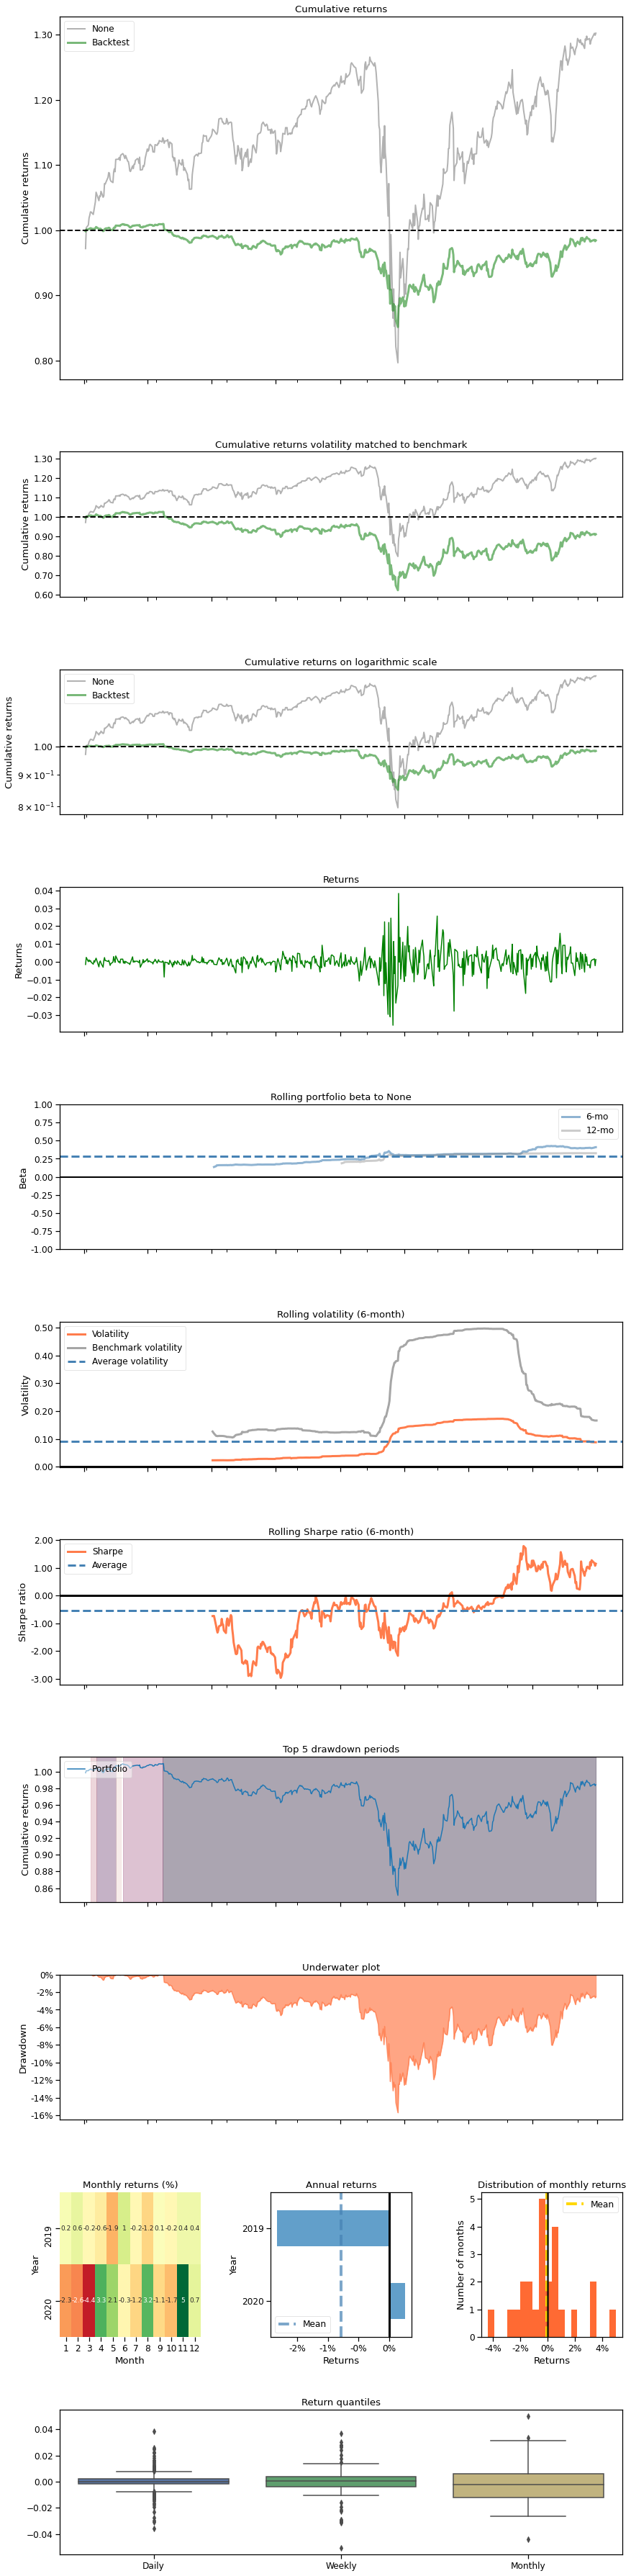

In [ ]:
print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(df_account_value, 
             baseline_ticker = '^DJI', 
             baseline_start = '2019-01-01',
             baseline_end = '2021-01-01', value_col_name = 'total_assets')

<a id='6.3'></a>
## 7.3 Baseline Stats

In [ ]:
print("==============Get Baseline Stats===========")

baseline_df = get_baseline(
        ticker="^DJI", 
        start = '2019-01-01',
        end = '2021-01-01')

baseline_stats = backtest_stats(baseline_df, value_col_name = 'close')

==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (505, 8)
Annual return          0.144674
Cumulative returns     0.310981
Annual volatility      0.274619
Sharpe ratio           0.631418
Calmar ratio           0.390102
Stability              0.116677
Max drawdown          -0.370862
Omega ratio            1.149365
Sortino ratio          0.870084
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.860710
Daily value at risk   -0.033911
Alpha                  0.000000
Beta                   1.000000
dtype: float64
